#### Feature Selection

I'm going to explore relationships between features I've chosen for analysis to figure out which of them are most valuable when predicting the price

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Loading the data
train = pd.read_csv('../datasets/predictors.csv')
test = pd.read_csv('../datasets/target.csv')

In [3]:
# Getting rid of ids so they don't mess up calculations
train.drop(columns = ['id'], inplace = True)
test.drop(columns = ['id'], inplace = True)

In [4]:
train.head()

,lot_area,land_slope,central_air,gr_liv_area,totrms_abvgrd,new_property,saleprice,paved,irregular,cul_de_sac,positive_feature,noisy,years_old,non-living,baseline,condition,floating_village
0,13517,0,1,1479,6,0,130500,1,1,1,0,1,5,769.0,135000.0,28,0
1,11492,0,1,2122,8,0,220000,1,1,1,0,0,12,987.0,181000.0,26,0
2,7922,0,1,1057,5,0,109000,1,0,0,0,0,3,1109.0,141000.0,22,0
3,9802,0,1,1444,7,0,174000,1,0,0,0,0,3,484.0,220000.0,24,0
4,14235,0,1,1445,6,0,138500,1,1,0,0,0,17,735.0,181000.0,24,0


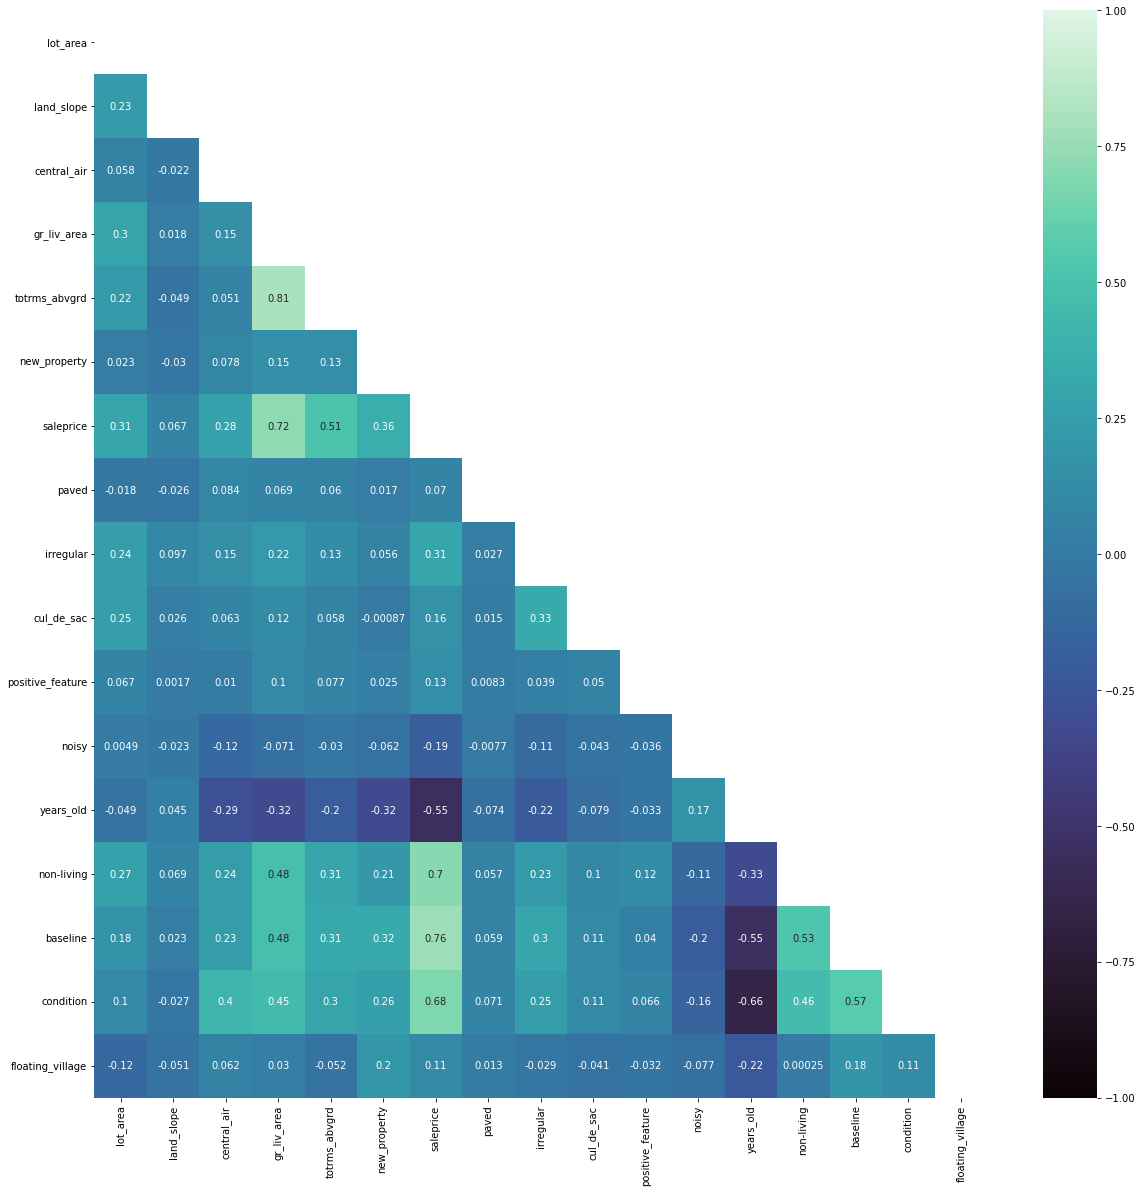

In [5]:
# Exploring correlation between features
# Heatmap
plt.figure(figsize = (20, 20))

mask = np.zeros_like(train.corr()) # creating mask
mask[np.triu_indices_from(mask)] = True

sns.heatmap(train.corr(),
           annot = True,
           vmin = -1,
           vmax = 1,
           cmap = 'mako',
           mask = mask);

In [6]:
train.corr()['saleprice'].sort_values()

years_old          -0.550697
noisy              -0.187936
land_slope          0.067388
paved               0.070117
floating_village    0.106359
positive_feature    0.133518
cul_de_sac          0.162127
central_air         0.275390
irregular           0.307072
lot_area            0.307474
new_property        0.360645
totrms_abvgrd       0.508568
condition           0.680362
non-living          0.704399
gr_liv_area         0.719262
baseline            0.758931
saleprice           1.000000
Name: saleprice, dtype: float64

Based on the heatmap, these are the key factors contributing to the price of the property in descending order of influence
1. Baseline price
3. Living Area Square Footage
4. Non-living Area Square Footage
2. Condition
1. Years since last renovation / construction
1. Number of rooms
1. If property is brand new?
1. Lot area
1. Irregular shape of the parcel
1. Central Air Conditioning
1. Noisy neighborhood


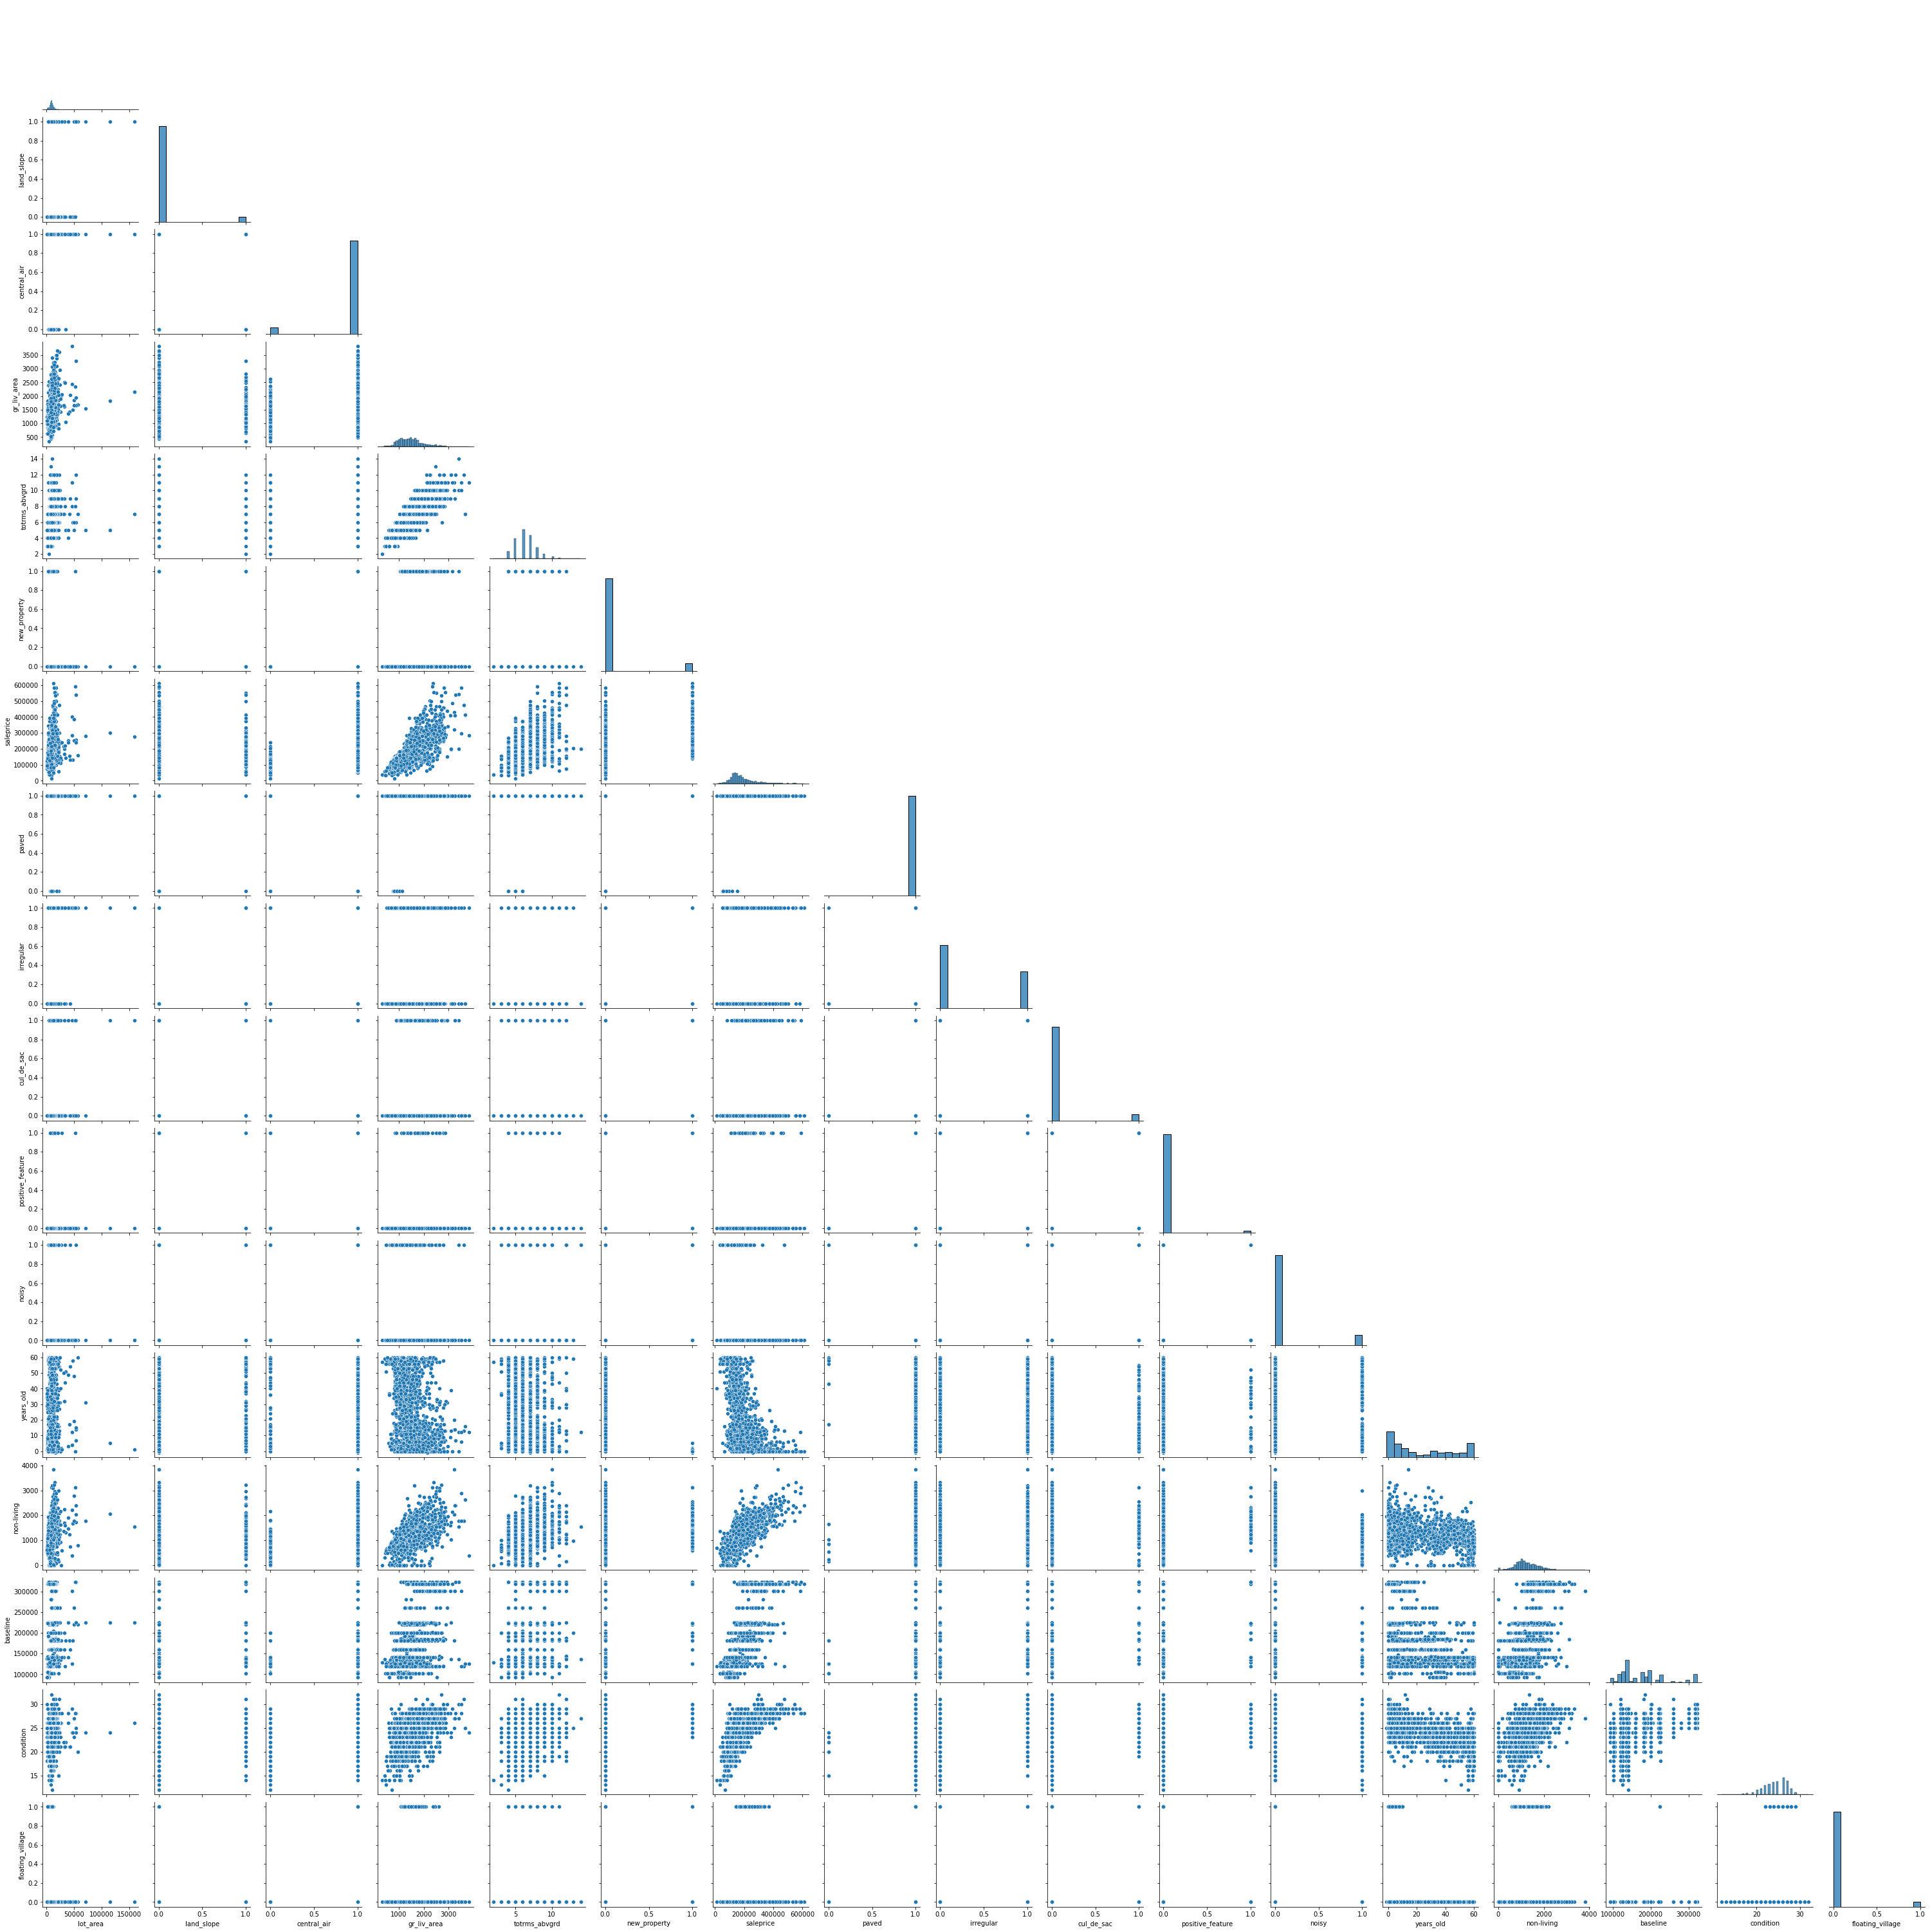

In [7]:
# Which relationships between features and target are linear?
sns.pairplot(train, corner = True);

#### Model 1: Multiple Linear Regression using all features

Let's start by creating a Linear Regression model using all features so we have our first baseline for model perfomance. As long as features have different units, like square footage and number of rooms, I'm going to scale them so they impact the prediction equally.

In [8]:
# Setting X and y
X = train.drop(columns = ['saleprice'])
y = train.saleprice

In [9]:
# Instantiating a StandardScaler
sc = StandardScaler()

# Fitting train features into it
sc.fit(X)

# Transforming train features
X_scaled = sc.transform(X)

# Transforming Test data the same way
Z_test = sc.transform(test)

In [10]:
# Splitting the scaled training data to another level of test and train, so we can evaluate the model ourselves before Kaggle submission
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.15) 

# I chose 0.15 because in my opinion we have too few data points

In [11]:
# Checking shapes of the train and test datasets
print(f'Training set: {X_train.shape, y_train.shape}')
print(f'Test set: {X_test.shape, y_test.shape}')

Training set: ((1739, 16), (1739,))
Test set: ((307, 16), (307,))


In [12]:
# Instantiating Linear Regression
lr_all = LinearRegression()

# Fitting training data into regression
lr_all.fit(X_train, y_train)

# Checking scores
print(f' Cross validation scores: {cross_val_score(lr_all, X_train, y_train)}')
print(f' Baseline score: {cross_val_score(lr_all, X_train, y_train).mean()}')

 Cross validation scores: [0.83238758 0.81200114 0.84481618 0.85353635 0.85034248]
 Baseline score: 0.8386167456460452


In [13]:
# Looking at train and test scores
print(f'Training R2: {lr_all.score(X_train, y_train)}')
print(f'Testing R2: {lr_all.score(X_test, y_test)}')

Training R2: 0.8447063612575915
Testing R2: 0.862238269367303


Not bad model perfomance. 84 - 85% of the price variability can be explained by features we included as predictors. What about coefficients - individual slopes of features?

In [14]:
# Intercept
lr_all.intercept_

181377.67068381238

In [15]:
# Individual coefficients
lr_all_coefs = pd.DataFrame(lr_all.coef_, index = X.columns)
lr_all_coefs

,0
lot_area,4082.445444
land_slope,2034.443202
central_air,-494.497107
gr_liv_area,28144.743996
totrms_abvgrd,-4461.090225
new_property,8069.894788
paved,-176.169158
irregular,519.340641
cul_de_sac,2415.387432
positive_feature,3116.005289


These coefficients are too large in my opinion. I would blame multicollinearity, because things like living area and non-living area have a strong positive correlation. 

In [16]:
# Calculating predictions
preds_all_test = lr_all.predict(X_test) # predicting saleprice for test sample created at test-train split for our own validation
preds_all = lr_all.predict(Z_test) # predicting saleprice on the dataset for Kaggle submission. IMPORTANT: test data was scaled

# Calculating residuals
residuals = y_test - preds_all_test

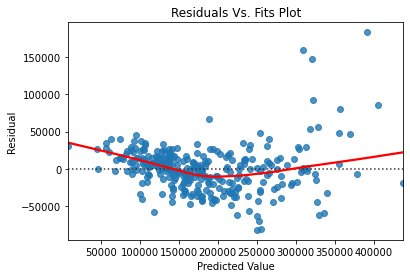

In [17]:
# LINEM assuptions validation
sns.residplot(x = preds_all_test,
              y = residuals,
              lowess = True, #help visualize relationship
              line_kws = {'color': 'red'})\
    .set(title = 'Residuals Vs. Fits Plot',
        xlabel = 'Predicted Value',
        ylabel = 'Residual');

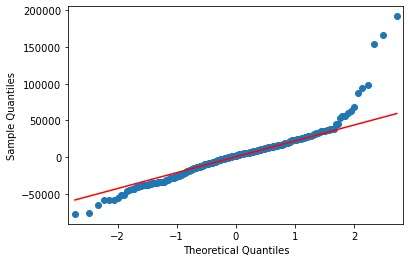

In [18]:
#q-q plot
sm.qqplot(residuals,
          dist=stats.norm,
          line='q');

Q-Q plot above indicates that data is skewed. Histogram should tell us more about the skew. 

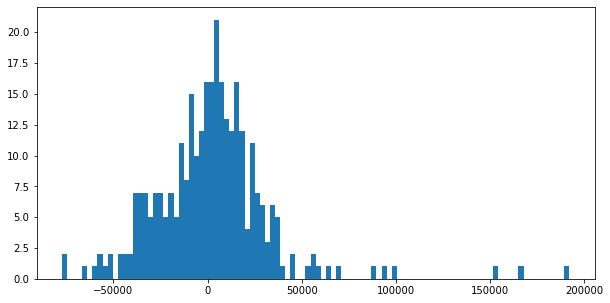

In [19]:
plt.figure(figsize = (10, 5))
plt.hist(residuals, bins = 100);

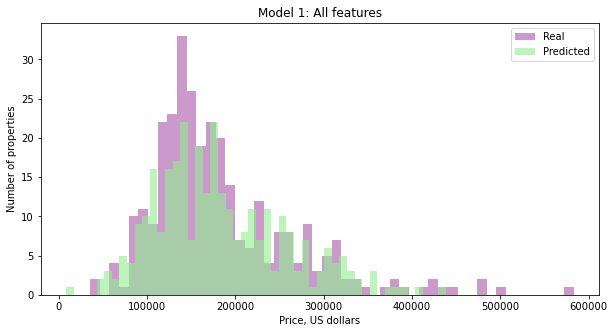

In [20]:
# Visualising predicted and real values overlap
plt.figure(figsize = (10,5))
plt.hist(y_test, color = 'purple', alpha = 0.4, bins = 50, label = 'Real')
plt.hist(preds_all_test, color = 'lightgreen', alpha = 0.6, bins = 50, label = 'Predicted');
plt.title('Model 1: All features')
plt.xlabel('Price, US dollars')
plt.ylabel('Number of properties')
plt.legend()
plt.savefig('../images/Model_1.png', dpi = 200);

In [21]:
# Another check for multicollinearity - Variance Inflation Factor
cols = X.columns 
res = [variance_inflation_factor(X_train, n) for n in range(0, len(X.columns))]
res_series = pd.Series(res, index = cols)

In [22]:
res_series

lot_area            1.288873
land_slope          1.085607
central_air         1.234023
gr_liv_area         3.993329
totrms_abvgrd       3.144385
new_property        1.191868
paved               1.018805
irregular           1.281406
cul_de_sac          1.185516
positive_feature    1.027034
noisy               1.061805
years_old           2.012784
non-living          1.672091
baseline            2.094880
condition           2.315743
floating_village    1.135917
dtype: float64

##### Saving and exporting predictions

In [23]:
# Now I need to export my predictions and format them properly for Kaggle submission
# Earlier I removed id column, but I need it now, so doing csv import again
test_orig = pd.read_csv('../datasets/target.csv')

In [24]:
# Converting array to DataFrame using train indexes
preds_all = pd.DataFrame(preds_all, index = test_orig.index) 
id_df = test_orig[['id']] # extracting ids from test data so I can perform merge
preds_all = pd.concat([id_df, preds_all], axis = 1) # adding ids to predictions so Kaggle can match them to real prices
preds_all.columns = ('Id', 'SalePrice') # fixing column names
preds_all.to_csv('../datasets/lr_all.csv', index = False) # saving result

I got score: 33722.65444 on Kaggle with this model. Not perfect, but it's something so far.

In [25]:
# I'm going to create function that produces a properly formatted csv based for challenge submission based on workflow I just came up with
def kaggle(predictions, name):
    '''
    Function that takes predictions and model name as string and returns a csv file with a proper format for Kaggle submission
    '''
    preds = pd.DataFrame(predictions, index = test_orig.id)
    id_df = test_orig[['id']]
    preds = pd.concat([id_df, preds], axis = 1)
    preds.columns = ('Id', 'SalePrice')
    preds_all.to_csv(('../datasets/' + str(name) + '.csv'), index = False)
    print(f'{name} is saved')

##### Feature Engineering (yes, again)

The model and its analysis along with some ongoing EDA in the preceding section leaded to the following conclusions:
* There is a multicollinearity between several features that has to be addressed.
    * Merge living and non-living area 
    * Number of rooms to be removed since it's collinear with square footage
    * Age must be removed too, because it's highly negatively correlated with condition
* Some of the features do not affect the price at all, so I'm going to drop features with lowest correlations to the price:
    * Paved
    * Slope  

In [26]:
# Reloading the data to start from scratch
train = pd.read_csv('../datasets/predictors.csv')
test = pd.read_csv('../datasets/target.csv')

In [27]:
# Merging square footage
train['sq_ft'] = train['gr_liv_area'] + train['non-living']
test['sq_ft'] = test['gr_liv_area'] + test['non-living']

In [28]:
# Getting rid of excessive columns
train.drop(columns = ['id', 'gr_liv_area', 'non-living', 'totrms_abvgrd', 'years_old', 'paved', 'land_slope'], inplace = True)
test.drop(columns = ['id', 'gr_liv_area', 'non-living', 'totrms_abvgrd', 'years_old', 'paved', 'land_slope'], inplace = True)

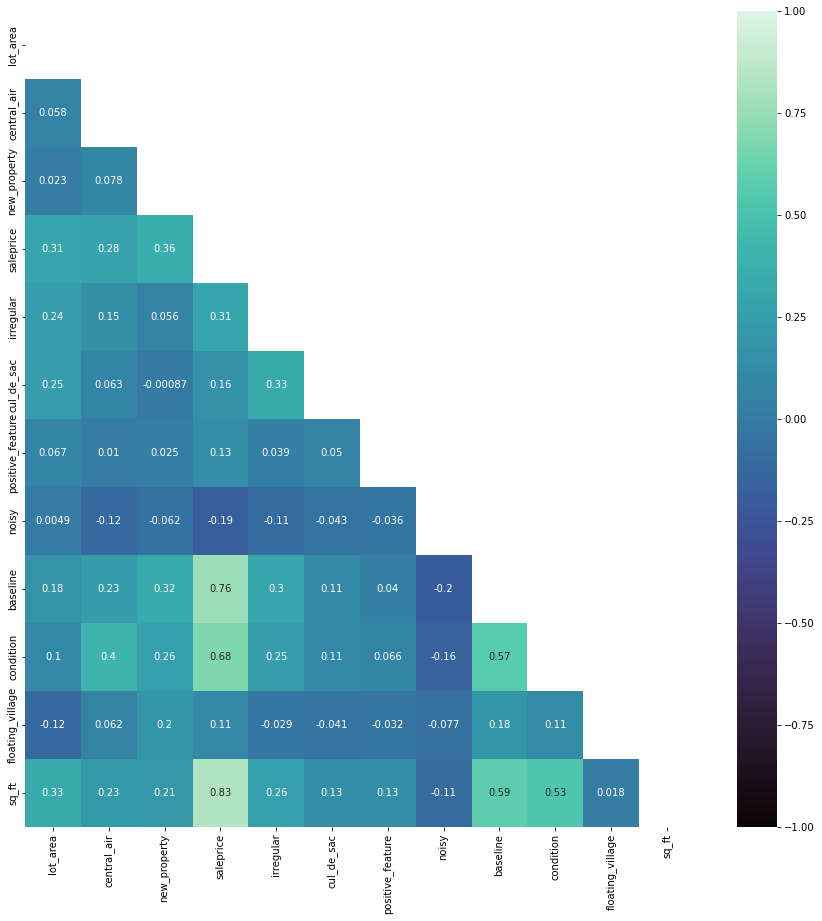

In [29]:
# How does the new heatmap look?

plt.figure(figsize = (15, 15))

mask = np.zeros_like(train.corr()) # mask
mask[np.triu_indices_from(mask)] = True

sns.heatmap(train.corr(),
           annot = True,
           vmin = -1,
           vmax = 1,
           cmap = 'mako',
           mask = mask);

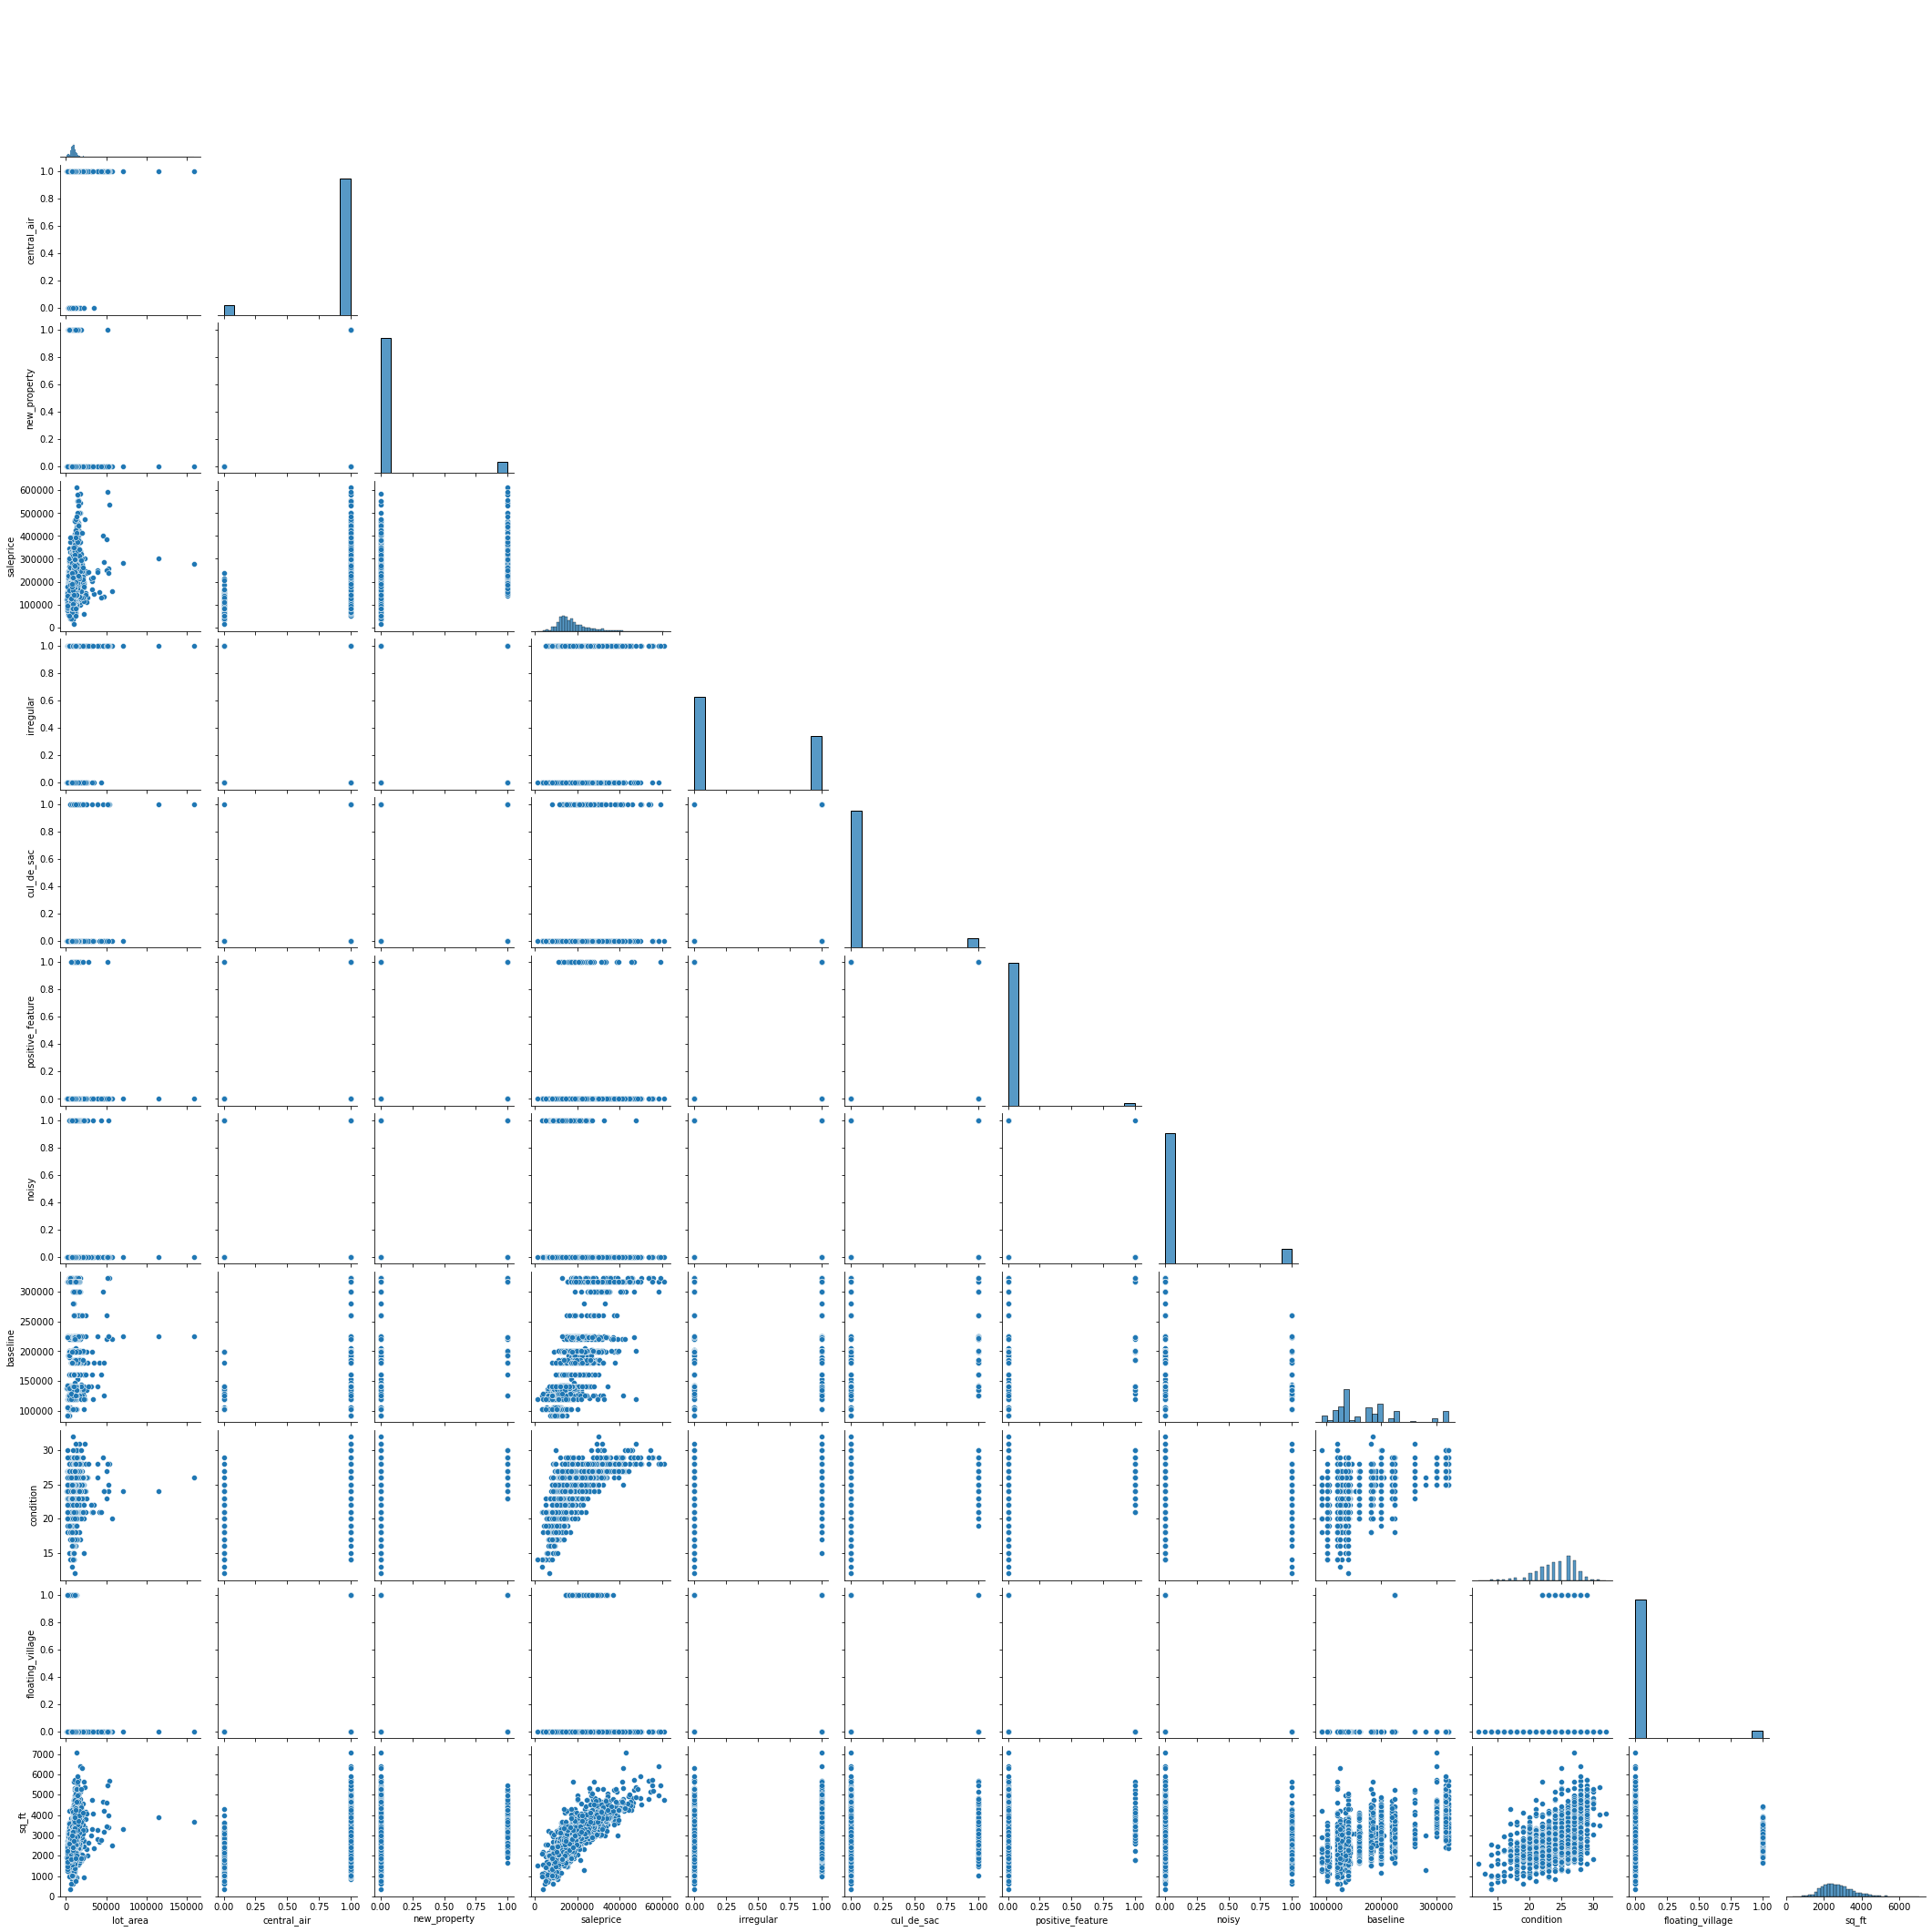

In [30]:
# And pairplot?
sns.pairplot(train, corner = True);

Well, don't see a lot collinear features anymore. Let's see how our new sample performs.

#### Model 2: Model 1 but without multicollinearity

In [31]:
# Setting X and y
X = train.drop(columns = ['saleprice'])
y = train.saleprice

# Scaling
sc = StandardScaler() # instantiating a StandardScaler
sc.fit(X) # fitting train data 
Z_train = sc.transform(X) # transforming train data
Z_test = sc.transform(test) # transforming test data

# Splitting training data to another level of test and train
X_train, X_test, y_train, y_test = train_test_split(Z_train, y, test_size = 0.15) 

# Instantiating another Linear Regression
lr = LinearRegression()

# Fitting training data into regression
lr.fit(X_train, y_train)

# Checking scores
print(f' Cross validation scores: {cross_val_score(lr, X_train, y_train)}')
print(f' New baseline score: {cross_val_score(lr, X_train, y_train).mean()}')

 Cross validation scores: [0.83076986 0.82551316 0.84019957 0.84079455 0.86091897]
 New baseline score: 0.8396392218947641


R squared is basically the same as before.

In [32]:
# Looking at train and test scores
print(f'Training R2: {lr.score(X_train, y_train)}')
print(f'Testing R2: {lr.score(X_test, y_test)}')

Training R2: 0.8445392742484092
Testing R2: 0.8425767378746106


In [33]:
# Intercept
lr.intercept_

181609.54553234164

In [34]:
# Coefficients
lr_coefs = pd.DataFrame(lr.coef_, index = X.columns)
lr_coefs

,0
lot_area,4188.108453
central_air,-1008.916382
new_property,7916.831202
irregular,1260.851960
cul_de_sac,1908.404263
positive_feature,2808.966068
noisy,-2574.096777
baseline,24120.809927
condition,16929.090898
floating_village,-1.032718


In [35]:
# Predictions
predictions = lr.predict(X_test) # our validation
predictions_test = lr.predict(Z_test) # Kaggle submission

# Calculating residuals
residuals = y_test - predictions

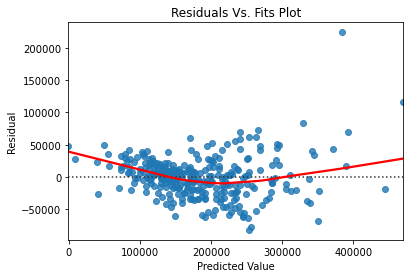

In [36]:
# LINEM assumptions
sns.residplot(x = predictions,
              y = residuals,
              lowess = True, #help visualize relationship
              line_kws = {'color': 'red'})\
    .set(title = 'Residuals Vs. Fits Plot',
        xlabel = 'Predicted Value',
        ylabel = 'Residual');

Residuals look more linear now.

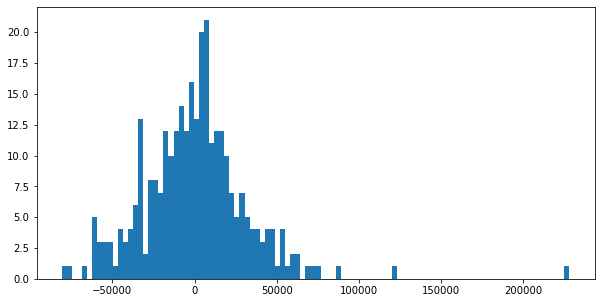

In [37]:
plt.figure(figsize = (10, 5))
plt.hist(residuals, bins = 100);

N assumption is better with this data, since distribution is more normal.

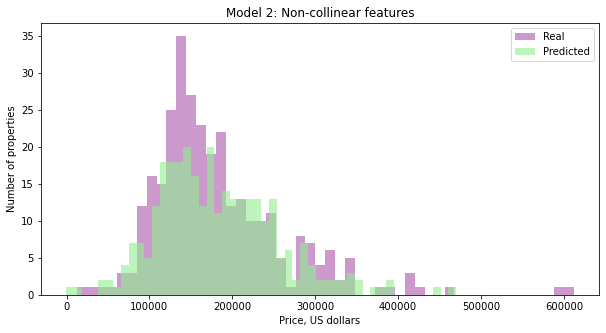

In [38]:
# Visualising predicted and real values overlap
plt.figure(figsize = (10,5))
plt.hist(y_test, color = 'purple', alpha = 0.4, bins = 50, label = 'Real')
plt.hist(predictions, color = 'lightgreen', alpha = 0.6, bins = 50, label = 'Predicted');
plt.title('Model 2: Non-collinear features')
plt.xlabel('Price, US dollars')
plt.ylabel('Number of properties')
plt.legend()
plt.savefig('../images/Model_2.png', dpi = 200);

Our new model is performing bad at 100 - 200k prices. Maybe this is something that can be fixed with polynomial features.

In [39]:
# Double check for multicollinearity - Variance Inflation Factor
cols = X.columns 
res = [variance_inflation_factor(X_train, n) for n in range(0, len(X.columns))]
res_series = pd.Series(res, index = cols)
res_series

lot_area            1.219763
central_air         1.211271
new_property        1.170701
irregular           1.261169
cul_de_sac          1.170911
positive_feature    1.025935
noisy               1.055406
baseline            1.981481
condition           1.873992
floating_village    1.098825
sq_ft               1.869303
dtype: float64

No multicolinearity, that means that next model improvement can be done by feature engineering and model tuning.

#### Model 3: Lasso and Polynomial features 

In [40]:
# Setting X and y
X = train.drop(columns = ['saleprice'])
y = train.saleprice

In [41]:
# Scaling
sc = StandardScaler() # instantiating a StandardScaler
sc.fit(X) # fitting train data 
Z_train = sc.transform(X) # transforming train data
Z_test = sc.transform(test) # transforming test data

In [42]:
# Instantiate PolynomialFeatures
poly = PolynomialFeatures(include_bias=False)

# Create X_poly (train data)
X_poly = poly.fit_transform(Z_train)

# Transform test data
Test_poly = poly.transform(Z_test)

In [43]:
# View X_poly in a DataFrame
pd.DataFrame(X_poly, columns = poly.get_feature_names_out(test.columns)).head()

,lot_area,central_air,new_property,irregular,cul_de_sac,positive_feature,noisy,baseline,condition,floating_village,...,baseline^2,baseline condition,baseline floating_village,baseline sq_ft,condition^2,condition floating_village,condition sq_ft,floating_village^2,floating_village sq_ft,sq_ft^2
0,0.531256,0.271021,-0.289286,1.310394,3.823391,-0.14121,2.949014,-0.706404,1.320178,-0.227877,...,0.499007,-0.932579,0.160973,0.407849,1.742869,-0.300838,-0.762216,0.051928,0.131567,0.333343
1,0.224143,0.271021,-0.289286,1.310394,3.823391,-0.14121,-0.339096,0.074034,0.609834,-0.227877,...,0.005481,0.045148,-0.016871,0.033068,0.371897,-0.138967,0.272391,0.051928,-0.101785,0.199510
2,-0.317285,0.271021,-0.289286,-0.763129,-0.261548,-0.14121,-0.339096,-0.604608,-0.810855,-0.227877,...,0.365551,0.490249,0.137776,0.408041,0.657485,0.184775,0.547234,0.051928,0.153791,0.455470
3,-0.032163,0.271021,-0.289286,-0.763129,-0.261548,-0.14121,-0.339096,0.735710,-0.100511,-0.227877,...,0.541269,-0.073947,-0.167651,-0.704772,0.010102,0.022904,0.096284,0.051928,0.218295,0.917665
4,0.640148,0.271021,-0.289286,1.310394,-0.261548,-0.14121,-0.339096,0.074034,-0.100511,-0.227877,...,0.005481,-0.007441,-0.016871,-0.048732,0.010102,0.022904,0.066159,0.051928,0.149997,0.433272


In [44]:
# Splitting training data to another level of test and train
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.15) 

# Instantiating another Linear Regression
lr = LinearRegression()

# Fitting training data into regression
lr.fit(X_train, y_train)

# Checking scores
print(f' Cross validation scores: {cross_val_score(lr, X_train, y_train)}')
print(f' New baseline score: {cross_val_score(lr, X_train, y_train).mean()}')

 Cross validation scores: [ 8.75207989e-01  8.67255164e-01  8.87139311e-01  8.83026481e-01
 -1.13902018e+18]
 New baseline score: -2.278040358869423e+17


In [45]:
# Looking at train and test scores
print(f'Training R2: {lr.score(X_train, y_train)}')
print(f'Testing R2: {lr.score(X_test, y_test)}')

Training R2: 0.8999517759790396
Testing R2: -1.338586850340694e+20


Scores don't make sense, probably the model is overfit at this point.

Lasso regularization is a good way to point out irrelevant features.

In [46]:
# Creating a list of alphas to check
l_alphas = np.logspace(-3, 0, 100)
# Cross-validate over alphas
lasso_cv = LassoCV(alphas = l_alphas)
# Fit model using best ridge alpha!
lasso_cv.fit(X_train, y_train)

/Users/mariiasundeeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 298494575621.21783, tolerance: 864011991.6329792
  model = cd_fast.enet_coordinate_descent_gram(
/Users/mariiasundeeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 298435762063.86774, tolerance: 864011991.6329792
  model = cd_fast.enet_coordinate_descent_gram(
/Users/mariiasundeeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 282620882579.44574, tolerance: 864011991.6329792
  model = cd_fast.enet_coordinate_descent_gram(
/Users/mariiasundeeva/opt/an

LassoCV(alphas=array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.00351119, 0.00376494,
       0.00403702, 0.00432876, 0.00464159, 0.00497702, 0.0053367 ,
       0.00572237, 0.00613591, 0.00657933, 0.0070548 , 0.00756463,
       0.008...
       0.09326033, 0.1       , 0.10722672, 0.1149757 , 0.12328467,
       0.13219411, 0.14174742, 0.15199111, 0.16297508, 0.17475284,
       0.18738174, 0.2009233 , 0.21544347, 0.23101297, 0.24770764,
       0.26560878, 0.28480359, 0.30538555, 0.32745492, 0.35111917,
       0.37649358, 0.40370173, 0.43287613, 0.46415888, 0.49770236,
       0.53366992, 0.57223677, 0.61359073, 0.65793322, 0.70548023,
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ]))

In [47]:
# Checking performance
print(lasso_cv.score(X_train, y_train))
print(lasso_cv.score(X_test, y_test))

0.8999564971730725
0.9048644027866493


In [48]:
cross_val_score(lasso_cv, X_train, y_train).mean()

/Users/mariiasundeeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 276168262657.16486, tolerance: 699946713.5228212
  model = cd_fast.enet_coordinate_descent_gram(
/Users/mariiasundeeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 247296616025.59924, tolerance: 699946713.5228212
  model = cd_fast.enet_coordinate_descent_gram(
/Users/mariiasundeeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 237418547467.66064, tolerance: 699946713.5228212
  model = cd_fast.enet_coordinate_descent_gram(
/Users/mariiasundeeva/opt/an

0.8735694675433952

In [49]:
# What is an optimal value of alpha?
lasso_cv.alpha_

1.0

In [50]:
# Let's see what features are most important according to lasso coefficients
lasso_coeffs = lasso_cv.coef_
lasso_coeffs = pd.Series(lasso_coeffs, index = poly.get_feature_names_out(test.columns))

In [51]:
lasso_coeffs[lasso_coeffs > 0].sort_values()

cul_de_sac condition              291.629032
lot_area positive_feature         440.215175
sq_ft^2                           566.225593
central_air noisy                 605.982264
new_property irregular            661.844495
new_property cul_de_sac           671.891167
irregular floating_village        676.678970
central_air cul_de_sac            953.515462
new_property baseline            1128.291840
lot_area irregular               1240.159233
noisy^2                          1868.172599
positive_feature condition       2035.913812
cul_de_sac floating_village      2161.829776
lot_area sq_ft                   2375.969260
noisy baseline                   2537.507365
irregular cul_de_sac             2992.968929
cul_de_sac                       3022.379843
irregular condition              3375.309935
lot_area floating_village        4455.962789
baseline floating_village        4665.820812
baseline sq_ft                   5413.875168
positive_feature                 6051.849378
new_proper

In [52]:
lasso_coeffs[lasso_coeffs < 0].sort_values()

irregular^2                     -28431.143706
central_air new_property        -27329.063401
noisy                            -7277.886955
baseline^2                       -5992.407306
central_air baseline             -4236.848771
new_property^2                   -3806.454909
floating_village                 -2100.517543
floating_village sq_ft           -2083.315164
irregular sq_ft                  -2083.160749
noisy condition                  -2077.266048
irregular baseline               -1959.963169
condition^2                      -1795.694411
cul_de_sac^2                     -1669.094541
noisy sq_ft                      -1542.577772
central_air irregular            -1529.708065
condition floating_village       -1451.908575
new_property floating_village    -1410.200339
new_property condition           -1255.669605
central_air positive_feature     -1237.494827
central_air sq_ft                -1020.987393
lot_area central_air              -884.718635
new_property noisy                

In [53]:
# Predictions
predictions = lasso_cv.predict(X_test) # our validation
predictions_test = lasso_cv.predict(Test_poly) # Kaggle submission

# Calculating residuals
residuals = y_test - predictions

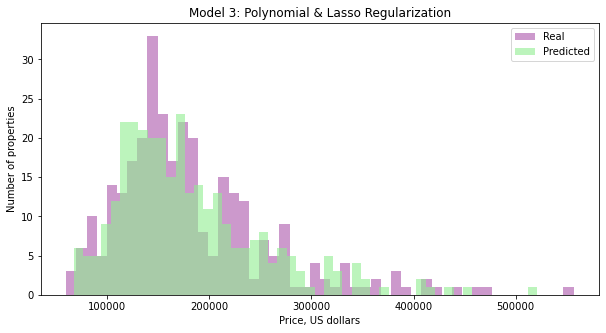

In [54]:
# Visualising predicted and real values overlap
plt.figure(figsize = (10,5))
plt.hist(y_test, color = 'purple', alpha = 0.4, bins = 50, label = 'Real')
plt.hist(predictions, color = 'lightgreen', alpha = 0.6, bins = 50, label = 'Predicted');
plt.title('Model 3: Polynomial & Lasso Regularization')
plt.xlabel('Price, US dollars')
plt.ylabel('Number of properties')
plt.legend()
plt.savefig('../images/Model_3.png', dpi = 200);

In [55]:
kaggle(predictions_test, 'lasso') # Export of predictions

lasso is saved


#### Model 4: Ridge

##### Ridge Regularization

Whereas Lasso works well for tuning coefficients for different features, Ridge regularization is good for improving model perfomance.
I'm going to use the same features as in model 2 and apply ridge method on that data.

In [56]:
# Repeating Model 2' setup 

# Setting X and y
X = train.drop(columns = ['saleprice'])
y = train.saleprice

# Scaling
sc = StandardScaler() # instantiating a StandardScaler
sc.fit(X) # fitting train data 
Z_train = sc.transform(X) # transforming train data
Z_test = sc.transform(test) # transforming test data

# Splitting training data to another level of test and train
X_train, X_test, y_train, y_test = train_test_split(Z_train, y, test_size = 0.15) 

# Instantiating another Linear Regression
lr = LinearRegression()

# Fitting training data into regression
lr.fit(X_train, y_train)

# Checking scores
print(f' Cross validation scores: {cross_val_score(lr, X_train, y_train)}')
print(f' New baseline score: {cross_val_score(lr, X_train, y_train).mean()}')

 Cross validation scores: [0.84917599 0.84508511 0.83301201 0.86862436 0.83026999]
 New baseline score: 0.8452334915385624


In [57]:
# Looking at train and test scores
print(f'Training R2: {lr.score(X_train, y_train)}')
print(f'Testing R2: {lr.score(X_test, y_test)}')

Training R2: 0.8487923559867007
Testing R2: 0.8110160784165941


In [58]:
# Applying ridge
alphas = np.logspace(0, 5, 100) # 100 values between 0 and 5

# Cross-validation over alphas
ridge_cv = RidgeCV(alphas = alphas, cv = 5)

# Fitting model with best alpha
ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        cv=5)

In [59]:
# Best alpha
ridge_cv.alpha_

11.497569953977356

In [60]:
# Best score
ridge_cv.best_score_

0.8452507463258678

In [61]:
# Scores for Train and Test datasets
print(ridge_cv.score(X_train, y_train))
print(ridge_cv.score(X_test, y_test))

0.8487814532892068
0.8109484851421576


Apparently, Ridge regularization didn't alter model perfomance.

In [62]:
# Predictions
predictions = ridge_cv.predict(X_test) # our validation
predictions_test = ridge_cv.predict(Z_test) # Kaggle submission

# Calculating residuals
residuals = y_test - predictions

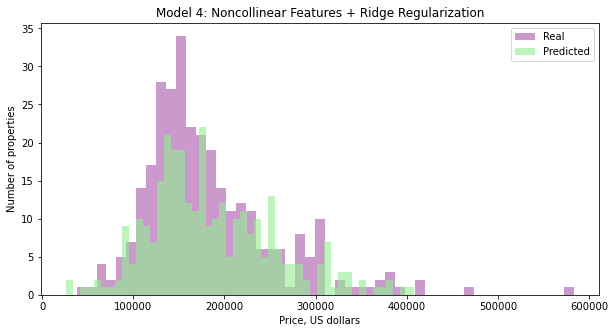

In [64]:
# Visualising predicted and real values overlap
plt.figure(figsize = (10,5))
plt.hist(y_test, color = 'purple', alpha = 0.4, bins = 50, label = 'Real')
plt.hist(predictions, color = 'lightgreen', alpha = 0.6, bins = 50, label = 'Predicted');
plt.title('Model 4: Noncollinear Features + Ridge Regularization')
plt.xlabel('Price, US dollars')
plt.ylabel('Number of properties')
plt.legend()
plt.savefig('../images/Model_4.png', dpi = 200);